# Modelo de classificação de risco de crédito com o dataset ***Home Credit Default Risk***
Let's Code 850 / Python e Dados
Projeto do Módulo IX - Marchine Learning II

### Resumo / Walkthrough do projeto

01. Limpeza de dados e EDA
02. Inspeção de *features* para separação entre numéricas e categóricas

03. Divisão do *dataset* em treino e teste

04. Balanceamento do *dataset* por meio de *undersampling*

05. Remoção das *features target* e *id* dos conjuntos ```xtrain``` e ```xtest```

06. Definição do conjunto ```ytest``` apenas com a *target feature*

07. Construção da *pipeline*
    * Para as *features* numéricas: *Simple Imputer* com preenchimento de dados pela média e padronização *StandardScaler*
    * *Features* categoricas: *Simple Imputer* com *OneHotEnconder*
    * *Cross validation* com *StratifiedKfold*
    * Estimadores utilizados: KNN, Random Forest, Adaboost, SVC<br></br>
    
08. Avaliação recursiva das features por meio do *Random Forest Classifier*

09. Construção do modelo (*fit transform*, *predict*)

10. Avaliação do melhor estimador com as métricas de eficácia
    * ROC AUC, *confusion matrix*, *classification report*<br></br>

11. Discussão dos resultados

12. Aplicação do modelo no *dataset* ```apptest``` e exportação dos resultados ```predict_proba``` para o arquivo final

### Pontos principas a respeito das técnicas aplicadas
feature selection é um ponto crucial, boa seleção das features para garantir um bom modelo é o mais trabalhoso
otimização, grid search ponto de partida dos hiperparâmetros é por tentativa e erro
setar as pipelines entender o q está acontecendo dentro das pipelines
modelos que demoram para rodar, encontrar o ponto ideal entre desenpenho do modelo e tempo de execução

### Dificuldades encontradas

Dificuldades q tem a ver com o dataset
* muitas features e muitos registros
* *Missing values* e tratamentos necessários
- **Exclusão das features que apresentavam muitos `NA` values**. (Explicar e quantificar)
- **Variáveis categóricas**. (Explicar dataset foi dividido depois novamente dividido em função da qtd de valores únicos, depois foi feito pente fino)

### Carregando os dados

In [84]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import scipy.stats as stats

from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
app_test = pd.read_csv('credito-imoveis/application_test_student.csv')

In [4]:
app_train = pd.read_csv('credito-imoveis/application_train.csv')
app_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0
5,270576,0,Cash loans,M,Y,Y,0,157500.0,630000.0,30307.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
6,378296,1,Cash loans,F,N,Y,0,72000.0,197820.0,15534.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
7,110095,0,Cash loans,M,Y,Y,0,90000.0,271957.5,18927.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
8,212537,0,Revolving loans,F,N,Y,0,162000.0,202500.0,10125.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
9,417346,0,Cash loans,M,Y,Y,0,90000.0,1350000.0,37255.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0


### Limpeza e tratamento

#### 1. Verificação de campos nulos

In [5]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

  
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
# Missing values statistics



In [6]:
missing_values = missing_values_table(app_train)
missing_values

,Missing Values,% of Total Values
COMMONAREA_MEDI,171978,69.9
COMMONAREA_AVG,171978,69.9
COMMONAREA_MODE,171978,69.9
NONLIVINGAPARTMENTS_MEDI,170914,69.5
NONLIVINGAPARTMENTS_MODE,170914,69.5
...,...,...
EXT_SOURCE_2,544,0.2
AMT_GOODS_PRICE,226,0.1
AMT_ANNUITY,10,0.0
DAYS_LAST_PHONE_CHANGE,1,0.0


In [7]:
feature_drop = list(missing_values[missing_values['% of Total Values'] >= 47.5].index)
feature_drop

['COMMONAREA_MEDI',
 'COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_AVG',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'BASEMENTAREA_MEDI',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'EXT_SOURCE_1',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'NONLIVINGAREA_AVG',
 'ELEVATORS_MEDI',
 'ELEVATORS_MODE',
 'ELEVATORS_AVG',
 'WALLSMATERIAL_MODE',
 'APARTMENTS_MODE',
 'APARTMENTS_MEDI',
 'APARTMENTS_AVG',
 'ENTRANCES_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_MODE',
 'LIVINGAREA_AVG',
 'HOUSETYPE_MODE',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BEGINEXPLUATATION

In [8]:

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train= app_train.drop(columns=feature_drop)

### 2. Separação de features (numéricas | categóricas)

In [9]:
def get_categorical_features(df,limite):
    categorical_features, numerical_features = [], []
    for col in df.columns:
        if df[col].nunique() < limite or type(col) == object:
            categorical_features.append(col)
        else:
            numerical_features.append(col)
    return categorical_features, numerical_features

In [10]:
categorical_features, numerical_features = get_categorical_features(app_train,15)
df_categorical = app_train[categorical_features]
df_numerical = app_train[numerical_features]

In [11]:
numerical_new=['CNT_CHILDREN','DEF_30_CNT_SOCIAL_CIRCLE' ,'DEF_60_CNT_SOCIAL_CIRCLE' ,'AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_QRT'] 

In [12]:
numerical_ant=['OCCUPATION_TYPE','ORGANIZATION_TYPE']

In [13]:
SK_ID_CURR=['SK_ID_CURR']

df_categorical_new=df_categorical.drop(columns=numerical_new)
df_categorical_new=pd.concat([df_categorical_new,app_train[numerical_ant]],axis=1)

print('new: ',df_categorical_new.shape)
print('antigo: ',df_categorical.shape)

new:  (246008, 47)
antigo:  (246008, 52)


In [14]:

df_numerical_new = pd.concat([df_numerical,app_train[numerical_new]],axis=1)
df_numerical_new = df_numerical_new.drop(columns=numerical_ant)
df_numerical_new = df_numerical_new.drop(columns=SK_ID_CURR)

print('new: ',df_numerical_new.shape)
print('antigo: ',df_numerical.shape)


new:  (246008, 25)
antigo:  (246008, 21)


In [15]:
df_concat = pd.concat([df_numerical_new, df_categorical_new], axis = 1 )

#### Tipo das colunas categoricas

In [16]:
type_num_cat = list(df_categorical_new.select_dtypes(include=np.number))[1:]

In [17]:
df_concat[type_num_cat] = df_concat[type_num_cat].astype('category')

### Treinamento

In [18]:
target='TARGET'
df_train,df_test= train_test_split(df_concat, train_size=0.7, random_state=42, stratify=df_concat[target])

In [19]:
n_zero,n_um=df_train[target].value_counts()
n_zero,n_um

(158226, 13979)

In [20]:
df_balanceado_1 = df_train[df_train[target]==1].copy()
df_balanceado_0 = df_train[df_train[target]==0].sample(n=n_um,replace=False,random_state=42)

df_balanceado = pd.concat([df_balanceado_1,df_balanceado_0])
df_balanceado.head(10)

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,...,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,OCCUPATION_TYPE,ORGANIZATION_TYPE
195471,121500.0,562491.0,24907.5,454500.0,0.003069,-22080,NaN,-1554.0,-4426,2.0,...,0,0,0,0,0,0,0,0,NaN,XNA
206736,135000.0,640080.0,24259.5,450000.0,0.018801,-11785,-4092.0,-727.0,-3916,4.0,...,0,0,0,0,0,0,0,0,Cleaning staff,Other
221827,81000.0,269550.0,16510.5,225000.0,0.025164,-21497,NaN,-7018.0,-4963,1.0,...,0,0,0,0,0,0,0,0,NaN,XNA
105113,112500.0,490495.5,30006.0,454500.0,0.003122,-23193,NaN,-10612.0,-4990,2.0,...,0,0,0,0,0,0,0,0,NaN,XNA
174713,247500.0,1293165.0,37939.5,1012500.0,0.035792,-16707,-845.0,-5641.0,-205,2.0,...,0,0,0,0,0,0,0,0,Sales staff,Business Entity Type 1
152428,135000.0,314100.0,16573.5,225000.0,0.018801,-9934,-1134.0,-1942.0,-2608,4.0,...,0,0,0,0,0,0,0,0,Laborers,Postal
78961,450000.0,2085120.0,72607.5,1800000.0,0.008019,-20135,-270.0,-5344.0,-562,2.0,...,0,0,0,0,0,0,0,0,NaN,Business Entity Type 3
240510,121500.0,545040.0,20677.5,450000.0,0.020713,-15464,-8816.0,-2772.0,-4409,1.0,...,0,0,0,0,0,0,0,0,Drivers,Electricity
20640,247500.0,527373.0,38506.5,477000.0,0.018801,-9600,-813.0,-4436.0,-2069,2.0,...,0,0,0,0,0,0,0,0,Laborers,Business Entity Type 3
76497,54000.0,450000.0,35685.0,450000.0,0.006852,-19427,-1725.0,-7653.0,-2977,2.0,...,0,0,0,0,0,0,0,0,NaN,Other


In [21]:
df_balanceado[target].value_counts()

1    13979
0    13979
Name: TARGET, dtype: int64

In [22]:
X_train = df_balanceado.drop(columns=[target])
#X_train = df_balanceado_n
y_train = df_balanceado[target]

X_test = df_test.drop(columns=[target])
#X_test = df_test_n
y_test = df_test[target]

In [23]:
features_num=df_numerical_new.columns.tolist()
#features_num=df_numerical_columns.tolist()
print(features_num)

features_cat=df_categorical_new.columns.tolist()
#features_cat=df_categorical_columns.tolist()
features_cat.remove(target)
print(features_cat)

['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CNT_CHILDREN', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT']
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',

In [24]:
pipe_feat_num = Pipeline([
    ('pre_input_num_mean', SimpleImputer(strategy='median')),
    ('pre_scaling_std', StandardScaler())
])

In [25]:
pipe_feat_cat = Pipeline([
    ('pre_input', SimpleImputer(strategy='most_frequent')),
    ('pre_one_hot', OneHotEncoder(drop='first',handle_unknown = 'ignore'))
])

In [26]:
pre_processor = ColumnTransformer([
    ('tr_num', pipe_feat_num, features_num),
    ('tr_cat', pipe_feat_cat, features_cat)
])

# Random Forest

In [27]:
pipe_final_RF = Pipeline([
    ('pre_processor', pre_processor),
    ('est', RandomForestClassifier(n_estimators = 250, min_samples_leaf = 4, max_depth = 20, random_state=42))
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

espaco_hiperparametros= {
    'est__n_estimators': np.linspace(150,250,3, dtype = int),
    'est__max_depth': np.linspace(2,20,10, dtype = int),
    'est__min_samples_leaf': np.linspace(1,10,10, dtype = int)
}
grid_search = GridSearchCV(pipe_final_RF, param_grid=espaco_hiperparametros, scoring='roc_auc', cv=cv, verbose=2, n_jobs=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

In [ ]:
roc_auc_score(y_test, y_pred)

#### Feature Selection

In [28]:
pipe_final_RF.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('pre_input_num_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CN...
                                                   'REG_REGION_NOT_WORK_REGION',
                                                   'LIVE_REGION_NOT_WORK_REGION',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'LIVE_CITY_NOT_WORK_CITY',
                                                   'FLAG_DOCUMENT_2',
                                                   'FLAG_DOCUMENT_3',
                                                   'FLAG_DOCUMENT_4',
                                                   'FLAG_DOCUMENT_5',
                                                   'FLAG_DOCUMENT_6',
                                                   'FLAG_DOCUMENT_7', ...])])),
                ('est',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        n_estimators=250, random_state=42))])

In [29]:
features = pipe_final_RF.feature_names_in_

In [30]:
feature_importances = pipe_final_RF.steps[1][1].feature_importances_

In [31]:
import plotly.express as px
f_i = list(zip(features,feature_importances))
f_i.sort(key = lambda x : x[1])
f_i = pd.DataFrame(f_i)
f_i = f_i[f_i[0] != 'CODE_GENDER']
fig = px.bar(f_i,x=1,y=0,orientation='h',labels={"1":"Feature importance","0":"Features"},title="Features selecionadas")
fig.show()

In [32]:
feature_new = f_i.sort_values(by=1,ascending=False)[0].tolist()[0:20]

In [33]:
f_i.sort_values(by=1,ascending=False)[1][0:20].sum()

0.7730846360758512

In [34]:
df_numerical_columns = df_numerical_new.columns[df_numerical_new.columns.isin(feature_new)]
df_categorical_columns = df_categorical_new.columns[df_categorical_new.columns.isin(feature_new)]

In [35]:
#feature selection
X_train = df_balanceado.loc[:,feature_new]
X_test = df_test.loc[:,feature_new]


In [36]:
features_num=df_numerical_columns.tolist()
features_cat=df_categorical_columns.tolist()

In [37]:
pre_processor = ColumnTransformer([
    ('tr_num', pipe_feat_num, features_num),
    ('tr_cat', pipe_feat_cat, features_cat)
])

In [38]:
pipe_final_RF = Pipeline([
    ('pre_processor', pre_processor),
    ('est', RandomForestClassifier(n_estimators = 250, min_samples_leaf = 4, max_depth = 20, random_state=42))
])

# KNN

In [39]:
pipe_final_KNN = Pipeline([
    ('pre_processor', pre_processor),
    ('est', KNeighborsClassifier(n_neighbors=242))
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
np.random.seed(42)
espaco_hiperparametros= {
    'est__n_neighbors': np.linspace(232,243,12,dtype=int),
}
grid_search = GridSearchCV(pipe_final_KNN, param_grid=espaco_hiperparametros, scoring='roc_auc', cv=cv, verbose=2, n_jobs=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

In [ ]:
roc_auc_score(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# TESTAR
df_result = pd.DataFrame(grid_search.cv_results_)
df_result

In [ ]:
df_result.plot(x = 'param_est__n_neighbors' , y = 'mean_test_score' );

# AdaBoost

In [85]:
model = AdaBoostClassifier(random_state=42,n_estimators=900,learning_rate=0.1)
pipe_final_AB= Pipeline([
    ('pre_processor', pre_processor),
    ('est', CalibratedClassifierCV(model, method='isotonic', cv=3))
    #('est', AdaBoostClassifier(random_state=42,n_estimators=800,learning_rate=0.1))
])

In [55]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

espaco_hiperparametros= {
    'est__n_estimators': [600, 700, 800,900],
    'est__learning_rate': [0.01, 0.1, 1, 10]
}
grid_search_ab = GridSearchCV(pipe_final_AB, param_grid=espaco_hiperparametros, scoring='roc_auc', cv=cv, verbose=2, n_jobs=2)

In [56]:
grid_search_ab.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processor',
                                        ColumnTransformer(transformers=[('tr_num',
                                                                         Pipeline(steps=[('pre_input_num_mean',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('pre_scaling_std',
                                                                                          StandardScaler())]),
                                                                         ['AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT_ANNUITY',
                                                                          'AMT_GOODS_PRICE',
                                                                          'REGION_POPULATI...
                                                                                         ('pre_one_hot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['REGION_RATING_CLIENT',
                                                                          'REGION_RATING_CLIENT_W_CITY',
                                                                          'REG_REGION_NOT_WORK_REGION'])])),
                                       ('est',
                                        AdaBoostClassifier(learning_rate=0.1,
                                                           n_estimators=800,
                                                           random_state=42))]),
             n_jobs=2,
             param_grid={'est__learning_rate': [0.01, 0.1, 1, 10],
                         'est__n_estimators': [600, 700, 800, 900]},
             scoring='roc_auc', verbose=2)

In [57]:
grid_search_ab.best_score_

0.7341516095208693

In [58]:
grid_search_ab.best_params_

{'est__learning_rate': 0.1, 'est__n_estimators': 900}

In [59]:
y_pred = grid_search_ab.best_estimator_.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 0])

In [78]:
y_pred_proba_RF_2 = grid_search_ab.best_estimator_.predict_proba(X_test)

In [79]:
y_pred_proba_RF_2

array([[0.49957263, 0.50042737],
       [0.49792285, 0.50207715],
       [0.49999959, 0.50000041],
       ...,
       [0.49866635, 0.50133365],
       [0.49951919, 0.50048081],
       [0.50262603, 0.49737397]])

In [80]:
roc_auc_score(y_test, y_pred_proba_RF_2[:,1])

0.7321427970127194

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_confusion_matrix(pipe_final_AB, X_test, y_test)

# SVC

In [41]:
pipe_final_SVC = Pipeline([
    ('pre_processor', pre_processor),
    ('est', SVC(random_state=42, kernel = 'linear', C = 10))
])

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

espaco_hiperparametros= {
    'est__kernel': ['poly', 'linear','rbf','sigmoid'], 
    'est__degree': [2,3],
    'est__C': [1,10,100]
}
grid_search = GridSearchCV(pipe_final_SVC, param_grid=espaco_hiperparametros, scoring='roc_auc', cv=cv, verbose=2, n_jobs=2)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_score_

In [ ]:
grid_search.best_params_

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_test)
y_pred

In [ ]:
roc_auc_score(y_test, y_pred)

# Avaliação do melhor estimador com as métricas de eficácia

## Comparação de estimadores (*confusion matrix*)

In [86]:
pipe_final_AB.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('pre_input_num_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CN...
                                                  Pipeline(steps=[('pre_input',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pre_one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'REG_REGION_NOT_WORK_REGION'])])),
                ('est',
                 CalibratedClassifierCV(base_estimator=AdaBoostClassifier(learning_rate=0.1,
                                                                          n_estimators=900,
                                                                          random_state=42),
                                        cv=3, method='isotonic'))])

In [42]:
#fit dos modelos 
pipe_final_KNN.fit(X_train, y_train)
pipe_final_RF.fit(X_train, y_train)
pipe_final_AB.fit(X_train, y_train)
pipe_final_SVC.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('pre_input_num_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CN...
                                                   'OBS_60_CNT_SOCIAL_CIRCLE',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('pre_input',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pre_one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'REG_REGION_NOT_WORK_REGION'])])),
                ('est', SVC(C=10, kernel='linear', random_state=42))])

In [43]:
#realizar as predições
y_pred_KNN = pipe_final_KNN.predict(X_test);
y_pred_RF = pipe_final_RF.predict(X_test);
y_pred_AB = pipe_final_AB.predict(X_test);
y_pred_SVC = pipe_final_SVC.predict(X_test);

#ROC AUC para cada estimador
roc_KNN = roc_auc_score(y_test, y_pred_KNN)
roc_RF = roc_auc_score(y_test, y_pred_RF)
roc_AB = roc_auc_score(y_test, y_pred_AB)
roc_SVC = roc_auc_score(y_test, y_pred_SVC)

In [44]:
#Classification reports
classification_KNN = classification_report(y_test, y_pred_KNN, output_dict=True)
classification_RF = classification_report(y_test, y_pred_RF, output_dict=True)
classification_AB = classification_report(y_test, y_pred_AB, output_dict=True)
classification_SVC = classification_report(y_test, y_pred_SVC, output_dict=True)

In [45]:
tabela_estimadores= {
    
    #'Algorítmo': ["KNN","RF","AB","SVC"],
    'ROC_AUC' : [roc_KNN,roc_RF,roc_AB,roc_SVC],
    'Precision (0)' : [classification_KNN["0"]["precision"],classification_RF["0"]["precision"],classification_AB["0"]["precision"],classification_SVC["0"]["precision"]],
    'Precision (1)' : [classification_KNN["1"]["precision"],classification_RF["1"]["precision"],classification_AB["1"]["precision"],classification_SVC["1"]["precision"]],
    'Recall (0)': [classification_KNN["0"]["recall"],classification_RF["0"]["recall"],classification_AB["0"]["recall"],classification_SVC["0"]["recall"]],
    'Recall (1)': [classification_KNN["1"]["recall"],classification_RF["1"]["recall"],classification_AB["1"]["recall"],classification_SVC["1"]["recall"]],
    'F1-Score (0)': [classification_KNN["0"]["f1-score"],classification_RF["0"]["f1-score"],classification_AB["0"]["f1-score"],classification_SVC["0"]["f1-score"]],
    'F1-Score (1)': [classification_KNN["1"]["f1-score"],classification_RF["1"]["f1-score"],classification_AB["1"]["f1-score"],classification_SVC["1"]["f1-score"]]

}
df_comparacao=pd.DataFrame(data=tabela_estimadores,index=["KNN","RF","AB","SVC"])
df_comparacao.index.name = "Algoritmo"
df_comparacao.style.background_gradient(cmap="RdYlGn")

,ROC_AUC,Precision (0),Precision (1),Recall (0),Recall (1),F1-Score (0),F1-Score (1)
Algoritmo,,,,,,,
KNN,0.654754,0.954834,0.145494,0.666210,0.643298,0.784827,0.237315
RF,0.670838,0.957469,0.156010,0.687194,0.654482,0.800124,0.251960
AB,0.674868,0.958267,0.158204,0.689745,0.659990,0.802130,0.255229
SVC,0.662890,0.955760,0.152198,0.684318,0.641462,0.797577,0.246023


/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



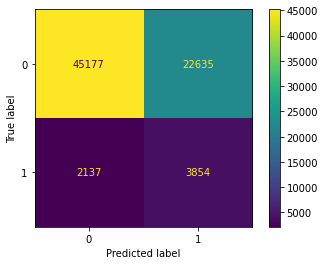

In [46]:
#confusion matrix
plot_confusion_matrix(pipe_final_KNN, X_test, y_test);

/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



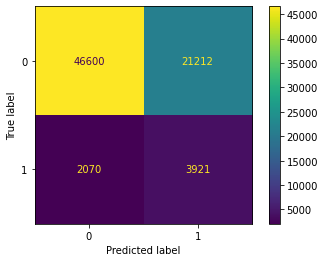

In [47]:
plot_confusion_matrix(pipe_final_RF, X_test, y_test);

/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



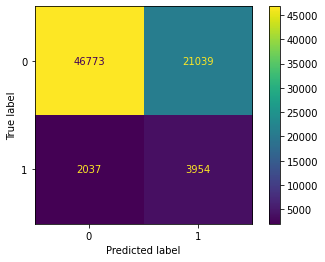

In [48]:
plot_confusion_matrix(pipe_final_AB, X_test, y_test);

/home/rafael/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



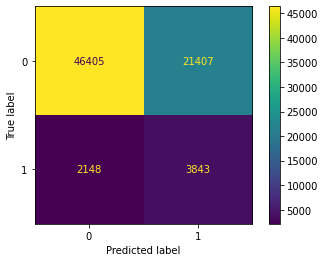

In [49]:
plot_confusion_matrix(pipe_final_SVC, X_test, y_test);

### Aplicação do modelo no dataset de teste final ```app_test``` com o Adaboost

In [66]:
y_pred_proba_KNN = pipe_final_KNN.predict_proba(app_test)

y_pred_proba_KNN

array([[0.34710744, 0.65289256],
       [0.65702479, 0.34297521],
       [0.43801653, 0.56198347],
       ...,
       [0.4338843 , 0.5661157 ],
       [0.39256198, 0.60743802],
       [0.49586777, 0.50413223]])

In [67]:
y_pred_proba_RF = pipe_final_RF.predict_proba(app_test)

y_pred_proba_RF

array([[0.28072869, 0.71927131],
       [0.78859138, 0.21140862],
       [0.46358206, 0.53641794],
       ...,
       [0.59896797, 0.40103203],
       [0.45268262, 0.54731738],
       [0.50235285, 0.49764715]])

In [74]:
roc = roc_auc_score(y_test, pipe_final_RF.predict_proba(X_test)[:,1])

In [75]:
roc

0.7282722364086447

In [81]:
y_test

185327    0
137722    1
64995     0
137981    0
160386    0
         ..
110586    0
226481    0
74703     0
3330      0
219422    1
Name: TARGET, Length: 73803, dtype: int64

In [87]:
roc = roc_auc_score(y_test, pipe_final_AB.predict_proba(X_test)[:,1])
roc

0.7321494971275806

In [89]:
y_pred_proba_AB = pipe_final_AB.predict_proba(app_test)

y_pred_proba_AB

array([[0.21390876, 0.78609124],
       [0.72213853, 0.27786147],
       [0.39489499, 0.60510501],
       ...,
       [0.05950243, 0.94049757],
       [0.55691939, 0.44308061],
       [0.58131196, 0.41868804]])

In [72]:
pipe_final_SVC.fit(X_train, y_train)

Pipeline(steps=[('pre_processor',
                 ColumnTransformer(transformers=[('tr_num',
                                                  Pipeline(steps=[('pre_input_num_mean',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('pre_scaling_std',
                                                                   StandardScaler())]),
                                                  ['AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CN...
                                                   'OBS_60_CNT_SOCIAL_CIRCLE',
                                                   'DAYS_LAST_PHONE_CHANGE',
                                                   'AMT_REQ_CREDIT_BUREAU_YEAR']),
                                                 ('tr_cat',
                                                  Pipeline(steps=[('pre_input',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('pre_one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['REGION_RATING_CLIENT',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'REG_REGION_NOT_WORK_REGION'])])),
                ('est', SVC(C=10, kernel='linear', random_state=42))])

In [ ]:
y_pred_proba_SVC = pipe_final_SVC.predict_proba(app_test)

y_pred_proba_SVC

In [ ]:
from numpy import savetxt

savetxt('predict_proba_final.csv',y_pred_proba,delimiter=',')